# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.

In [370]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from typing import Optional

## 1. Utility Functions

### 1.1. Activation Functions

- Sigmoid function: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Derivative of sigmoid function: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

- ReLU function: $f(z) = \max(0, z)$
- Derivative of ReLU function: $f'(z) = 0$ if $z < 0$ and $f'(z) = 1$ if $z \geq 0$

- Tanh function: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- Derivative of tanh function: $\tanh'(z) = 1 - \tanh^2(z)$

- Softmax function: $S(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$ for $j = 1, 2, \ldots, K$

### 1.2. Loss Functions

- Cross-entropy loss: $L(y, \hat{y}) = -\sum_{k} y_k \log(\hat{y}_k)$


In [371]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

In [372]:
def get_activation(activation: str):
    if activation == "sigmoid":
        return sigmoid, sigmoid_derivative
    elif activation == "relu":
        return relu, relu_derivative
    elif activation == "tanh":
        return np.tanh, tanh_derivative
    else:
        raise ValueError(f"Unknown activation function: {activation}")

In [373]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)


def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

### 1.2. Polling Functions

- Max pooling: $f(x, y) = \max(x, y)$
- Average pooling: $f(x, y) = \frac{x + y}{2}$
- L2 pooling: $f(x, y) = \sqrt{x^2 + y^2}$

### 1.3. Plotting Functions

In [374]:
def plot_data(
    X: np.ndarray, y: np.ndarray, y_proba: Optional[np.ndarray] = None
) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title)

    plt.tight_layout()
    plt.show()

## 2. Load Data

In [375]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

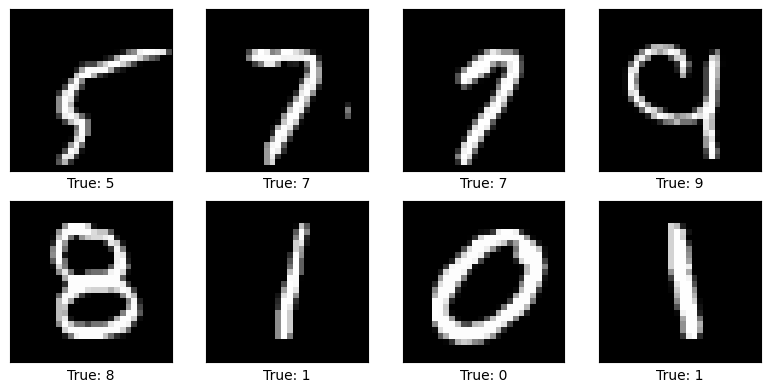

In [376]:
plot_data(X_train, y_train)

## 3. Image Preprocessing

In [377]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [378]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [379]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [380]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Feature Extraction

In [381]:
class Conv2d:
    def __init__(self, inp: np.ndarray, kernel_size: int) -> None:
        self.inp = inp
        self.kernel = np.random.randn(kernel_size, kernel_size)

        height, width = inp.shape
        self.out = np.zeros((height - kernel_size + 1, width - kernel_size + 1))

    def getROI(self):
        # ROI: Region of Interest
        for row in range(self.out.shape[0]):
            for col in range(self.out.shape[1]):
                yield row, col, self.inp[
                    row : row + self.kernel.shape[0], col : col + self.kernel.shape[1]
                ]

    def operation(self) -> np.ndarray:
        for row, col, roi in self.getROI():
            self.out[row, col] += np.sum(roi * self.kernel)

        return self.out

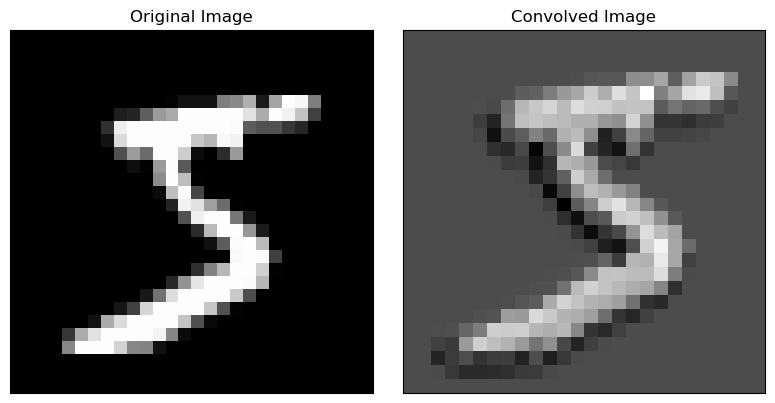

In [382]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

img = X_train[0, :, :, 0]
conv = Conv2d(img, 3)

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original Image")
axes[0].set(xticks=[], yticks=[])

axes[1].imshow(conv.operation(), cmap="gray")
axes[1].set_title("Convolved Image")
axes[1].set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

#### 4.1.2. Convolutional Neural Network Model

In [383]:
class Layer:
    def __init__(self, activation: str = "linear") -> None:
        self.activation, self.activation_derivative = get_activation(activation)

    def forward(self, X: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Forward pass of the layer
        net = X * w
        y = activation(net)
        """
        net = np.dot(X, w)
        return self.activation(net)

    def backward(
        self, X: np.ndarray, w: np.ndarray, e: np.ndarray, lr: float
    ) -> np.ndarray:
        """Backward pass of the layer
        phi = np.multiply(e, activation_derivative(y))
        w = w + lr * X.T * phi
        """
        phi = np.multiply(e, self.activation_derivative(w))
        newW = w + lr * np.dot(X.T, phi)
        return phi, newW

### 4.2 With Keras

In [384]:
inp_shape = X_train.shape[1:]

In [385]:
model = keras.models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [386]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [387]:
batch_size = 128
epochs = 15

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/15
352/422 [========================>.....] - ETA: 0s - loss: 0.4881 - accuracy: 0.8581

422/422 [==============================] - 1s 2ms/step - loss: 0.4486 - accuracy: 0.8695 - val_loss: 0.1040 - val_accuracy: 0.9693
Epoch 2/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0903 - accuracy: 0.9729 - val_loss: 0.0780 - val_accuracy: 0.9752
Epoch 3/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0545 - accuracy: 0.9824 - val_loss: 0.0721 - val_accuracy: 0.9798
Epoch 4/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0385 - accuracy: 0.9881 - val_loss: 0.0808 - val_accuracy: 0.9782
Epoch 5/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0666 - val_accuracy: 0.9792
Epoch 6/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0775 - val_accuracy: 0.9787
Epoch 7/15
422/422 [==============================] - 2s 4ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0811 - val_accuracy: 0.9797
Epoch 8/15
422/42

#### 4.2.1. Model results

In [388]:
history_dict = history.history

In [389]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [390]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

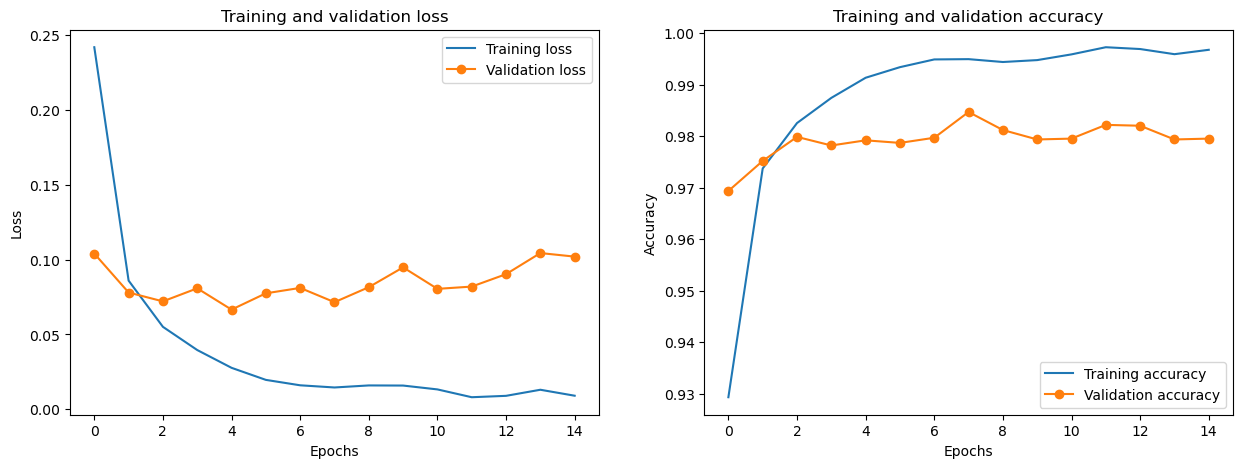

In [391]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_run = [i for i in range(epochs)]

ax1.plot(epochs_run, train_loss, label="Training loss")
ax1.plot(epochs_run, val_loss, label="Validation loss", marker="o")

ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs_run, train_acc, label="Training accuracy")
ax2.plot(epochs_run, val_acc, label="Validation accuracy", marker="o")

ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### 4.2.1. Model prediction

In [392]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09866596013307571
Test accuracy: 0.979200005531311


In [393]:
y_pred = model.predict(X_test)

In [394]:
np.argmax(y_pred, axis=1)

array([7, 2, 1, ..., 4, 5, 6])

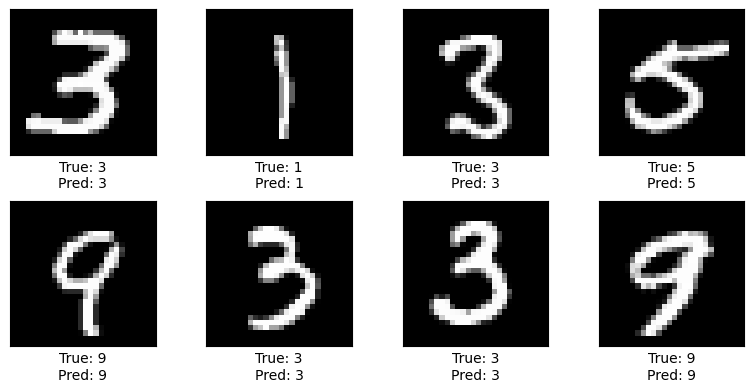

In [395]:
plot_data(X_test, np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))